# Address completeness classification with traditional programming techniques

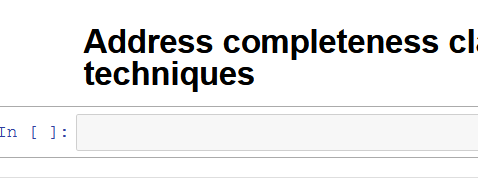